# Разведочный анализ данных

Набор данных состоит из 1655 цифровых рентгеновских изображений коленного сустава. Исходные изображения представляют собой 8-битные изображения в оттенках серого. Каждое рентгенологическое рентгеновское изображение коленного сустава вручную классифицировано в соответствии со специальными медицинскими оценками двумя экспертами на 5 классов.

Эксперт I:

1. Normal (515 шт.)
1. Doubtful (478 шт.)
2. Mild (233 шт.)
1. Moderate (222 шт.)
1. Severe (207 шт.)


Эксперт II:

1. Normal (504 шт.)
1. Doubtful (489 шт.)
1. Mild (233 шт.)
1. Moderate (222 шт.)
1. Severe (207 шт.)

Ссылка на данные: https://tnn-hse-medtech.storage.yandexcloud.net/datasets/

## Нужные импорты

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Собираем метаданные датасета

In [15]:
import re
import hashlib
from pathlib import Path
from dataclasses import dataclass

file_pattern = re.compile(r'\w+\s+\((\d+)\)\.png')
directory = Path('~/Downloads/hse/archive (1)').expanduser()

@dataclass()
class Metadata:
    expert: str
    file_id: str
    severity: int
    relative_path: str


def parse_path(file: Path) -> Metadata:
    data_bytes = file.read_bytes()
    hash1 = hashlib.sha256(data_bytes).hexdigest()
    hash2 = hashlib.md5(data_bytes).hexdigest()
    path = file.relative_to(directory)
    severity = str(path.parent.name)
    expert = str(path.parent.parent.name)
    return Metadata(expert, f'{hash1}:{hash2}', severity, str(path))

raw_data = []
for file in directory.rglob('*.png'):
    raw_data.append(parse_path(file))
len(raw_data)


3300

# Формирует датасет


In [16]:
data = pd.DataFrame(raw_data)
data


,expert,file_id,severity,relative_path
0,MedicalExpert-II,4aaa42fc773d639e09042d8ec920bf54035f75e9c582ee...,1Doubtful,MedicalExpert-II/1Doubtful/DoubtfulG1 (203).png
1,MedicalExpert-II,b411ded0928bc1ff918a1ec0eb1c288198704cfb3eb1b4...,1Doubtful,MedicalExpert-II/1Doubtful/DoubtfulG1 (346).png
2,MedicalExpert-II,d0efac1151dccaa60cb315154a0377b5ed5dac94369781...,1Doubtful,MedicalExpert-II/1Doubtful/DoubtfulG1 (17).png
3,MedicalExpert-II,7a347ac6be61298ffad51d01fa754ca81984e7b96d7c3c...,1Doubtful,MedicalExpert-II/1Doubtful/DoubtfulG1 (254).png
4,MedicalExpert-II,290079785724f5ca891e83213f480bc449b64e33c8db21...,1Doubtful,MedicalExpert-II/1Doubtful/DoubtfulG1 (311).png
...,...,...,...,...
3295,MedicalExpert-I,7a200b679888319db15ddd968dc576334377fda09acaf9...,3Moderate,MedicalExpert-I/3Moderate/ModerateG3 (58).png
3296,MedicalExpert-I,766f164b7594b58771ac969eb3d071951ad038dd2b6c1f...,3Moderate,MedicalExpert-I/3Moderate/ModerateG3 (123).png
3297,MedicalExpert-I,f976bbf37dce6ce8baaf4b64c9809dc79363d8614c29bc...,3Moderate,MedicalExpert-I/3Moderate/ModerateG3 (135).png
3298,MedicalExpert-I,03f9f83f5335a23d629f02343797568c44fdb41c4b3ec0...,3Moderate,MedicalExpert-I/3Moderate/ModerateG3 (19).png


In [17]:
data.dtypes


expert           object
file_id          object
severity         object
relative_path    object
dtype: object

# Нормализуем данные


In [18]:
severity_map = {
    '0Normal': 0,
    '1Doubtful': 1,
    '2Mild': 2,
    '3Moderate': 3,
    '4Severe': 4
}
data['severity'] = data['severity'].map(severity_map)


In [19]:
data.describe(include='object')


,expert,file_id,relative_path
count,3300,3300,3300
unique,2,1633,3300
top,MedicalExpert-II,197ee4a082d0ecd02972532453a8a7aaff300c2348352c...,MedicalExpert-II/1Doubtful/DoubtfulG1 (203).png
freq,1650,6,1


Вижно что часть хешей совпадает, значит какие-то файлы дублируются в выборке и их можно отбросить. Ищем такие файлы

In [45]:
# data[data['file_id'] in data.groupby('file_id').count]['relative_path']
duplicated_files = data[['file_id', 'relative_path', 'expert']].groupby(['file_id', 'expert'], as_index=False).agg('count')
duplicated_files = duplicated_files[duplicated_files['relative_path'] > 1]
duplicated_files


,file_id,expert,relative_path
310,197ee4a082d0ecd02972532453a8a7aaff300c2348352c...,MedicalExpert-I,3
311,197ee4a082d0ecd02972532453a8a7aaff300c2348352c...,MedicalExpert-II,3
364,1dcec59295c228968cfbe39c1e16028b25be68ea58c78b...,MedicalExpert-I,2
365,1dcec59295c228968cfbe39c1e16028b25be68ea58c78b...,MedicalExpert-II,2
898,451842e164a05a07973360035fceb73cb9b463eb5fe1c1...,MedicalExpert-I,2
899,451842e164a05a07973360035fceb73cb9b463eb5fe1c1...,MedicalExpert-II,2
1120,54cc7904e251af243e3033f895997e37a6976f4e5b78cb...,MedicalExpert-I,2
1121,54cc7904e251af243e3033f895997e37a6976f4e5b78cb...,MedicalExpert-II,2
1238,5c78a76c95d62132765bf5337c8ec0aab4bcf32d6dd97c...,MedicalExpert-I,2
1239,5c78a76c95d62132765bf5337c8ec0aab4bcf32d6dd97c...,MedicalExpert-II,2


Проверяем файлы

In [24]:
import PIL
from PIL import Image

paths = data[data['file_id'] == '197ee4a082d0ecd02972532453a8a7aaff300c2348352c866a1dba15cbb2554d:f0dc21fa5616728d830149fd3d0513bd']['relative_path']
images = []
for item in paths:
    image_path = directory / item
    with image_path.open('rb') as fp:
        image = Image.open(fp)
        image.load()
    images.append(image)


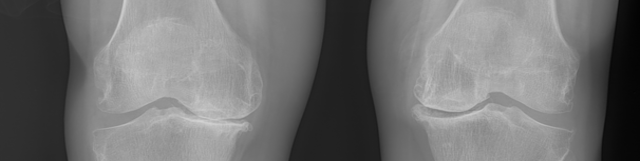

In [25]:
images[0]


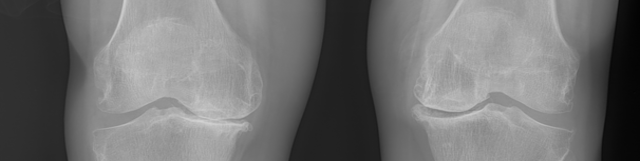

In [26]:
images[1]


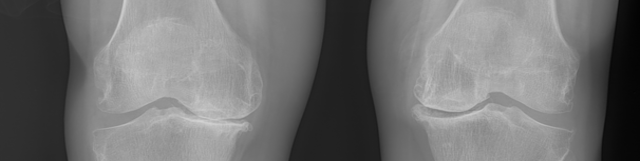

In [27]:
images[2]


Видно, что изображения идентичные. Проверяем, есть ли разные оценки для таких изображений от каждого эксперта в отдельности

In [51]:
duplicated_data = data[data['file_id'].isin(duplicated_files['file_id'])]
duplicated_data[['expert', 'severity', 'file_id']].groupby(['expert', 'file_id'], as_index=False).agg(['nunique', 'first'])


expert                                            file_id  \
                                                                          
0    MedicalExpert-I  197ee4a082d0ecd02972532453a8a7aaff300c2348352c...   
1    MedicalExpert-I  1dcec59295c228968cfbe39c1e16028b25be68ea58c78b...   
2    MedicalExpert-I  451842e164a05a07973360035fceb73cb9b463eb5fe1c1...   
3    MedicalExpert-I  54cc7904e251af243e3033f895997e37a6976f4e5b78cb...   
4    MedicalExpert-I  5c78a76c95d62132765bf5337c8ec0aab4bcf32d6dd97c...   
5    MedicalExpert-I  7a21c7e7f35d1b9cd50cd2bb50fb3c5893fe51806e3127...   
6    MedicalExpert-I  a2038be623857565ab04f5d050b49fad1cb9560abff33b...   
7    MedicalExpert-I  a584c0ac57356d4416e8501679c8eaea18afd71d69c03f...   
8    MedicalExpert-I  ae12756e91aa76578235cd53766a5c74991d2266589308...   
9    MedicalExpert-I  b1448f0ce641f512a7eb75bf195739bcd41517add88165...   
10   MedicalExpert-I  b1691371b73e79e3936f7aac9adf389a24c594adc056e4...   
11   MedicalExpert-I  b77349ed8bc71862a59379ef157bccb6381b74a077025b...   
12   MedicalExpert-I  d22bd4c1f75758819b1746090725b5338d3193631bdc6b...   
13   MedicalExpert-I  d97f89d4e1826abb55e1fa5868e27ee80bb3a8f0c8a86d...   
14   MedicalExpert-I  f96a0d0a156b931634ded8b4d77e0e0f1a99a2a1a25fa6...   
15  MedicalExpert-II  197ee4a082d0ecd02972532453a8a7aaff300c2348352c...   
16  MedicalExpert-II  1dcec59295c228968cfbe39c1e16028b25be68ea58c78b...   
17  MedicalExpert-II  451842e164a05a07973360035fceb73cb9b463eb5fe1c1...   
18  MedicalExpert-II  54cc7904e251af243e3033f895997e37a6976f4e5b78cb...   
19  MedicalExpert-II  5c78a76c95d62132765bf5337c8ec0aab4bcf32d6dd97c...   
20  MedicalExpert-II  7a21c7e7f35d1b9cd50cd2bb50fb3c5893fe51806e3127...   
21  MedicalExpert-II  a2038be623857565ab04f5d050b49fad1cb9560abff33b...   
22  MedicalExpert-II  a584c0ac57356d4416e8501679c8eaea18afd71d69c03f...   
23  MedicalExpert-II  ae12756e91aa76578235cd53766a5c74991d2266589308...   
24  MedicalExpert-II  b1448f0ce641f512a7eb75bf195739bcd41517add88165...   
25  MedicalExpert-II  b1691371b73e79e3936f7aac9adf389a24c594adc056e4...   
26  MedicalExpert-II  b77349ed8bc71862a59379ef157bccb6381b74a077025b...   
27  MedicalExpert-II  d22bd4c1f75758819b1746090725b5338d3193631bdc6b...   
28  MedicalExpert-II  d97f89d4e1826abb55e1fa5868e27ee80bb3a8f0c8a86d...   
29  MedicalExpert-II  f96a0d0a156b931634ded8b4d77e0e0f1a99a2a1a25fa6...   

   severity        
    nunique first  
0         1     3  
1         1     1  
2         1     3  
3         1     3  
4         1     2  
5         1     3  
6         1     1  
7         1     0  
8         1     2  
9         1     2  
10        1     2  
11        1     2  
12        1     3  
13        1     1  
14        1     3  
15        1     3  
16        1     1  
17        1     3  
18        1     3  
19        1     2  
20        1     3  
21        1     1  
22        1     0  
23        1     2  
24        1     2  
25        1     2  
26        1     2  
27        1     3  
28        1     1  
29        1     3

Оценки совпадают, значит можно откинуть дубликаты

In [56]:
deleted_paths = data[data.duplicated(['expert', 'file_id'], keep='first')]['relative_path']
deleted_paths


97      MedicalExpert-II/1Doubtful/DoubtfulG1 (392).png
227     MedicalExpert-II/1Doubtful/DoubtfulG1 (459).png
473      MedicalExpert-II/1Doubtful/DoubtfulG1 (79).png
770              MedicalExpert-II/2Mild/MildG2 (74).png
778             MedicalExpert-II/2Mild/MildG2 (101).png
840             MedicalExpert-II/2Mild/MildG2 (206).png
852             MedicalExpert-II/2Mild/MildG2 (211).png
916              MedicalExpert-II/2Mild/MildG2 (67).png
1338        MedicalExpert-II/0Normal/NormalG0 (294).png
1489    MedicalExpert-II/3Moderate/ModerateG3 (203).png
1515     MedicalExpert-II/3Moderate/ModerateG3 (89).png
1518     MedicalExpert-II/3Moderate/ModerateG3 (46).png
1535    MedicalExpert-II/3Moderate/ModerateG3 (217).png
1571     MedicalExpert-II/3Moderate/ModerateG3 (48).png
1608    MedicalExpert-II/3Moderate/ModerateG3 (207).png
1631    MedicalExpert-II/3Moderate/ModerateG3 (206).png
1633    MedicalExpert-II/3Moderate/ModerateG3 (210).png
1989      MedicalExpert-I/1Doubtful/DoubtfulG1 (

Сохраняем в файл для дальнейшего использования при фильтрации

In [59]:
deleted_paths.to_csv('deleted_paths.csv', index=False)


In [60]:
data = data.drop_duplicates(['expert', 'file_id'], keep='first')
data


,expert,file_id,severity,relative_path
0,MedicalExpert-II,4aaa42fc773d639e09042d8ec920bf54035f75e9c582ee...,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (203).png
1,MedicalExpert-II,b411ded0928bc1ff918a1ec0eb1c288198704cfb3eb1b4...,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (346).png
2,MedicalExpert-II,d0efac1151dccaa60cb315154a0377b5ed5dac94369781...,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (17).png
3,MedicalExpert-II,7a347ac6be61298ffad51d01fa754ca81984e7b96d7c3c...,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (254).png
4,MedicalExpert-II,290079785724f5ca891e83213f480bc449b64e33c8db21...,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (311).png
...,...,...,...,...
3295,MedicalExpert-I,7a200b679888319db15ddd968dc576334377fda09acaf9...,3,MedicalExpert-I/3Moderate/ModerateG3 (58).png
3296,MedicalExpert-I,766f164b7594b58771ac969eb3d071951ad038dd2b6c1f...,3,MedicalExpert-I/3Moderate/ModerateG3 (123).png
3297,MedicalExpert-I,f976bbf37dce6ce8baaf4b64c9809dc79363d8614c29bc...,3,MedicalExpert-I/3Moderate/ModerateG3 (135).png
3298,MedicalExpert-I,03f9f83f5335a23d629f02343797568c44fdb41c4b3ec0...,3,MedicalExpert-I/3Moderate/ModerateG3 (19).png


## Анализ нормализованных данных

Для начала посмотрим как сильно расходятся оценки у экспертов по файлам

In [123]:
cross_check = data.pivot(
    index='file_id', columns='expert', values='severity'
    ).reset_index()
cross_check


expert,file_id,MedicalExpert-I,MedicalExpert-II
0,000555ee2250db28d7ccb076cd8ed02dc46ad149255231...,0,0
1,001a4766d9a9cc32c1d7bc65b6a6d6fa6f18a5540f576e...,3,3
2,00439f2700963bfc89ab72a4fe7711299228d8db3fd4cb...,2,2
3,005c7b80497f04a63b685eafe6797d672754684a9317ac...,2,2
4,00668822b6f82a52fd186a0d8583f3e276bab809b32b71...,1,1
...,...,...,...
1628,fe910f9f5eea10fe03f6b8dbc10c4a318b55053aaa580b...,3,3
1629,fecd647553be61596154b3766dbe39a5d3b2b9fb2edede...,3,3
1630,ff49383c140e3cd433c0ed3d52c923378a7958482dd4e2...,1,1
1631,ff4bbd6aa27f3cf0e5d4ad3e2e83c025c16a8b372a82a0...,0,0


In [132]:
cross_check.groupby(
        ['MedicalExpert-I', 'MedicalExpert-II']
        ).agg('count')


expert                            file_id
MedicalExpert-I MedicalExpert-II         
0               0                     502
                1                      11
1               1                     474
2               2                     227
3               3                     213
4               4                     206

В основном оценки совпадают, но обнаружены 11 файлов, которые были оценены по разному

In [135]:
different_level = cross_check[(cross_check['MedicalExpert-II']!=cross_check['MedicalExpert-I'])]
different_level


expert,file_id,MedicalExpert-I,MedicalExpert-II
9,0184a61fb664048be62beaebd18350091b1da331469dc3...,0,1
250,283fb711f3d2f6af28b92ef4ab54c2ab98b7537fc7b278...,0,1
334,32dc600ef010e8251457ab912c242eb9f288b208059606...,0,1
361,37e674b83d1828aa25f4a370c499b691715bcb100485f0...,0,1
620,5cd936fc2c88c431ce72ab9f3e5cf2907e5827136318ba...,0,1
649,6144aa47b5c8f9d99ae704e0562a2d361ab9da5c13768e...,0,1
716,6b96ee74963e6cb9f3c6823cd5f563d31a032a63b843bb...,0,1
1183,b56d832cd973346c6504f2fb56ba673ac1c1bb49a6d064...,0,1
1195,b7ed43175bbd8d7a842ed60ce405c0119187c1faff8f7a...,0,1
1420,df1fb9f2f43783f68d2ae8de7052b2a1a9017fa9003442...,0,1


In [140]:
different_severity_paths = data[data['file_id']==different_level['file_id'].iloc[0]]['relative_path']
different_severity_paths


324     MedicalExpert-II/1Doubtful/DoubtfulG1 (5).png
2978       MedicalExpert-I/0Normal/NormalG0 (390).png
Name: relative_path, dtype: object

In [142]:
different_severity_images = []
for item in different_severity_paths:
    image_path = directory / item
    with image_path.open('rb') as fp:
        image = Image.open(fp)
        image.load()
    different_severity_images.append(image)


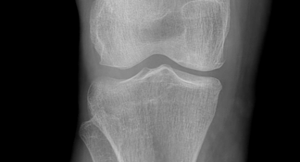

In [143]:
different_severity_images[0]


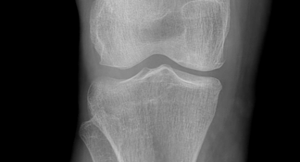

In [144]:
different_severity_images[1]


Сохраним пути таких файлов